In [1]:
from sctoolbox.utils.jupyter import bgcolor, _compare_version
from types import SimpleNamespace

# create a temporary mock of settings to avoid undefined errors and retain startup time
settings = SimpleNamespace()
final_clustering = None  # to avoid error on init

nb_name = "group_markers.ipynb"

_compare_version(nb_name)

/home/jdetlef/.conda/envs/sctoolbox/lib/python3.10/site-packages/sctoolbox/utils/jupyter.py:108: UserWarning: The notebook has an older version compared to the installed sctoolbox version (0.10.1 < 0.10.2b0). Some functions may not work!
  warnings.warn(f"The notebook has {ver_dif} version compared to the installed sctoolbox version ({nb_ver} {arrow} {sc_ver}). Some functions may not work!")


# Marker computation and analysis
<hr style="border:2px solid black"> </hr>

## 1 - Description

**Note: Requires the dataset to be split into groups/ clusters. This can be achieved using a clustering notebook e.g. `04_clustering.ipynb` for RNA.**

**Move this notebook into the notebook folder (e.g. `rna_analysis/notebooks/`) of the respective analysis before using it!**

An important part of most analysis is the identification and subsequent interpretation of changes between predefined groups. Most commonly, groups were based on experimental conditions (e.g. healthy vs. ill) with the aim of identifying differential features (e.g. genes) to explain the underlying mechanisms. With the increased resolution of single cell data another approach became viable, namely the identification of cell types. But before cell type assignment (see  `annotation.ipynb`) markers have to be identified which follows the same concept of identifying group specific differences.

This notebook is aimed at computing lists of potential markers, e.g. marker genes for RNA and marker peaks for ATAC, based on the selected groups and reviewing their performance through visualization. Two different methods are provided for the identification of group markers:

- The [rank_genes_groups()](https://scanpy.readthedocs.io/en/stable/generated/scanpy.tl.rank_genes_groups.html) method from scanpy.
- [DESeq2](https://doi.org/doi:10.18129/B9.bioc.DESeq2) a method originally intended for bulk that will be run by first creating pseudobulks from the given groups.

---------

## 2 - Loading packages

In [12]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.backends.backend_pdf

import sctoolbox
import sctoolbox.utils as utils
import sctoolbox.tools as tools
import sctoolbox.plotting as pl
from sctoolbox import settings

---------

## 3 - Loading adata

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [2]:
%bgcolor PowderBlue

# sctoolbox settings
settings.adata_input_dir = "../adatas/"
settings.adata_output_dir = "../adatas/"
settings.figure_dir = "../figures/markers/"
settings.table_dir = "../tables/markers/"
settings.log_file = "../logs/marker_log.txt"
settings.overwrite_log = True

anndata_file = "anndata_4.h5ad"

___

In [14]:
adata = utils.adata.load_h5ad(anndata_file)

with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata)
    display(adata.obs)

[INFO] The adata object was loaded from: ../adatas/anndata_4.h5ad


AnnData object with n_obs × n_vars = 6392 × 105042
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'nucleosome_signal', 'fld_score', 'mean_fragment_size', 'n_fragments', 'fold_change_promoters_fragments', 'frip', 'tsse_score', 'catlas_ov', 'cell type', 'closest Cell Ontology term(s)', 'mNSC', 'tc', 'peakqc', 'n_features', 'log1p_n_features', 'leiden_0.1', 'leiden_0.2', 'leiden_0.3', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7', 'leiden_0.8', 'leiden_0.9', 'clustering'
    var: 'peak_chr', 'peak_start', 'peak_end', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'annotation_feature', 'gene_strand', 'gene_start', 'gene_end', 'annotation_query', 'query_name', 'distance_to_gene', 'gene_anchor', 'gene_ovl_peak', 'peak_ovl_gene', 'relative_location_to_gene', 'gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype'
    uns: 'clustering_colors', 'files', 'leiden_0.1', 'lei

,TN,UM,PP,UQ,CM,file,sample,nucleosome_signal,fld_score,mean_fragment_size,n_fragments,fold_change_promoters_fragments,frip,tsse_score,catlas_ov,cell type,closest Cell Ontology term(s),mNSC,tc,peakqc,n_features,log1p_n_features,leiden_0.1,leiden_0.2,leiden_0.3,leiden_0.4,leiden_0.5,leiden_0.6,leiden_0.7,leiden_0.8,leiden_0.9,clustering
barcode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACTACCAGAAATAAGGCCAG,7244.0,6422.0,6403.0,6403.0,113.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.526786,1110.717402,139.16,6615.0,0.355502,0.414752,3.795517,True,Atrial Cardiomyocyte,regular atrial cardiac myocyte,True,True,True,2380,7.775276,1,1,1,1,1,1,1,1,1,1
AAACTACCAGAACATGAAGCGC,1895.0,1654.0,1649.0,1649.0,71.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.653846,171.855951,145.87,1592.0,0.291457,0.194095,1.574153,True,Endothelial Cell (General) 1,endothelial cell,True,True,True,291,5.676754,2,2,3,2,2,2,2,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTCCATCCTCTGGGCACATTAG,1553.0,1235.0,1233.0,1233.0,106.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.470588,118.560913,124.75,1117.0,0.256938,0.136079,1.497854,True,Endothelial Cell (General) 1,endothelial cell,True,True,True,155,5.049856,2,2,3,2,2,2,2,2,3,2
TTCCATCCTCTTAGTGCTAGCA,4475.0,3875.0,3866.0,3867.0,292.0,/mnt/workspace2/jdetlef/peakqc_paperprep/bench...,MB,0.481013,391.046807,132.70,3816.0,0.599581,0.331237,1.618242,True,Cardiac Fibroblasts,fibroblast of cardiac tissue,True,True,True,1168,7.063904,1,3,2,3,5,5,4,6,7,3


---------

## 4 - Select grouping
<hr style="border:2px solid black"> </hr>

Compute markers for all selected groupings and choose the optimal one based on the visualization. Ideally, markers should be only found within one group, causing the plot to show a "stair"-like pattern. The identified markers are typically used to assign cell types in downstream analysis.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [3]:
%bgcolor PowderBlue

# Column names of clustering columns
# Add all columns of interest
clustering_cols = ["clustering", "leiden_0.2", "leiden_0.3", "leiden_0.4", "leiden_0.5", "leiden_0.6", "leiden_0.7", "leiden_0.8", "leiden_0.9"]

# Marker features

# Method for feature ranking
ranking_method = "t-test"
# Top n features to be reported, None for all features
top_n = None

# Marker feature filter

# Minimum fraction of cells in a group that must express a feature to be considered as a marker
min_in_group_fraction = 0.25
# Minimum foldchange (+/-) to be considered as a marker
min_fold_change = 0.5
# Maximum fraction of cells in other groups that must express a feature to be considered as a marker
max_out_group_fraction = 0.8

# Plotting
n_features_markerplot = 15  # number of features to show per group
marker_style = "dots"  # Either `dots` or `heatmap`.

________

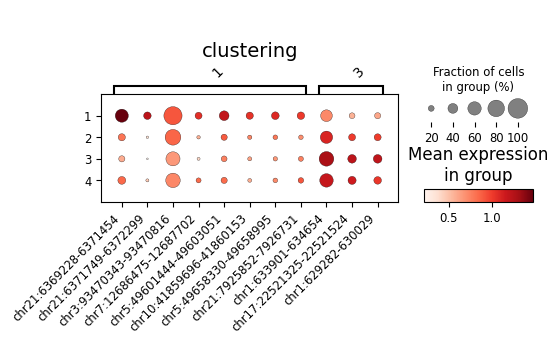

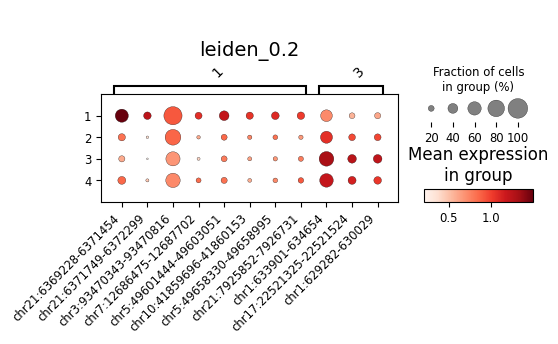

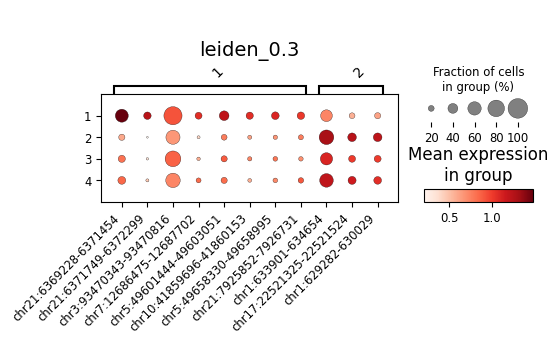

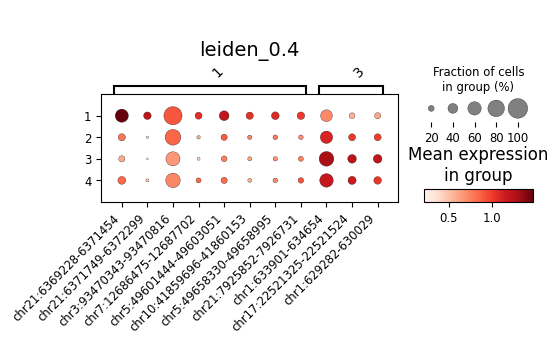

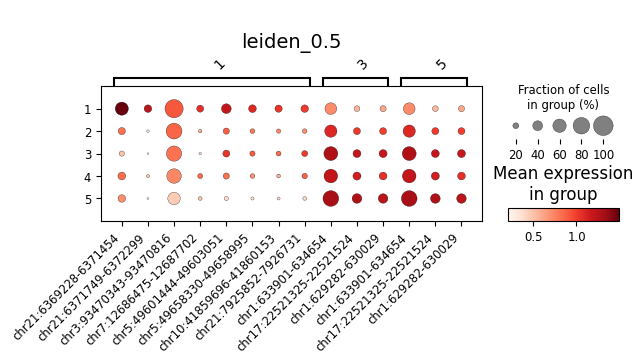

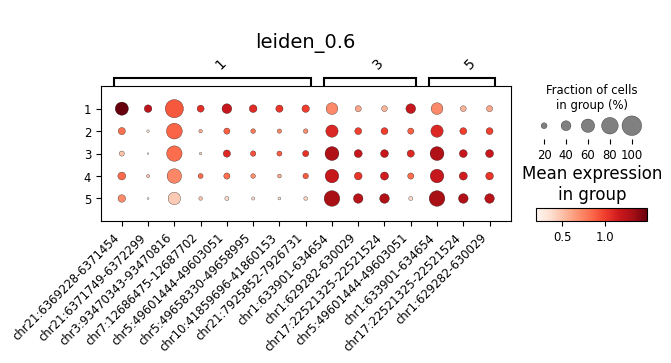

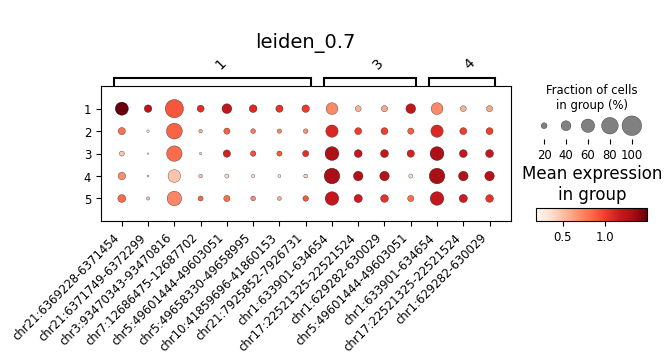

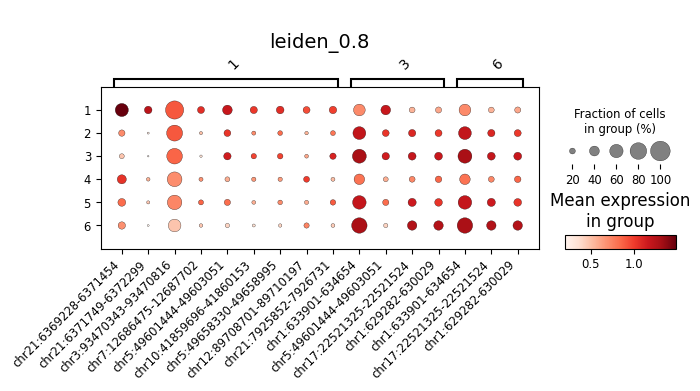

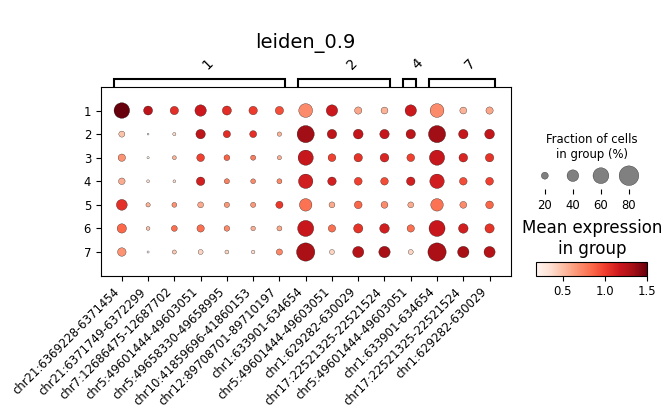

In [16]:
for clustering in clustering_cols:

    # Identify markers per cluster (adjust group fraction and fold change to filter features)
    tools.marker_genes.run_rank_genes(
        adata,
        clustering,
        min_in_group_fraction=min_in_group_fraction,
        min_fold_change=min_fold_change,
        max_out_group_fraction=max_out_group_fraction,
        n_genes=top_n,
        ranking_method=ranking_method,
        key_added=f"rank_feature_{clustering}"
    )

    # Plot dotplot of markers
    _ = pl.marker_genes.rank_genes_plot(
        adata,
        key=f"rank_feature_{clustering}_filtered",
        n_genes=n_features_markerplot,
        style=marker_style,
        title=clustering,
        save=f"marker_{marker_style}_{clustering}.pdf"
    )

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [4]:
%bgcolor PowderBlue

# choose the final clustering (grouping)
final_clustering = "clustering"

[INFO] Saved marker gene tables to '../tables/markers/marker_feature_clustering.xlsx'


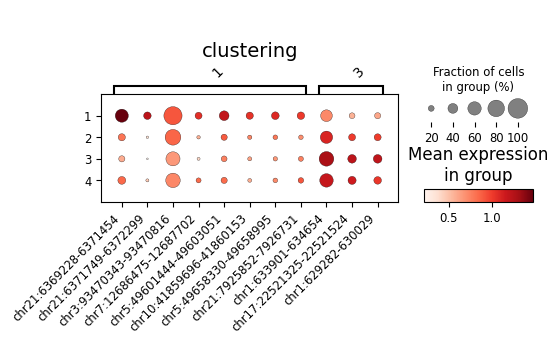

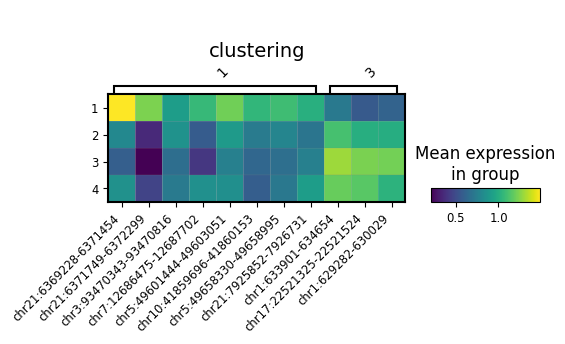

In [20]:
for m_style in ["dots", "heatmap"]:
    # Plot dotplot of markers
    _ = pl.marker_genes.rank_genes_plot(
        adata,
        key=f"rank_feature_{final_clustering}_filtered",
        n_genes=n_features_markerplot,
        style=m_style,
        title=final_clustering,
        save=f"marker_{m_style}_{final_clustering}.pdf"
    )

# Write marker genes to table
marker_table = tools.marker_genes.get_rank_genes_tables(
    adata,
    out_group_fractions=True,
    key=f"rank_feature_{final_clustering}_filtered",
    save_excel=f"marker_feature_{final_clustering}.xlsx"
)

---------

## 5 - Feature accumulation
<hr style="border:2px solid black"> </hr>

This section shows the location of cells within the embedding that express features. Features are either the top markers of the respective group or a user-provided list of features.

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [5]:
%bgcolor PowderBlue

# Top X marker to be plotted
n_marker = 5

# List of features additionally shown in the embedding.
custom_feat_list = []

# planet plot
# set the data which should be displayed on the x- and y-axis (adata.obs column names) to enable this plot
x = "phase"
y = final_clustering
log_scale=False

# embedding
embedding = "umap"  # Either umap or tsne
style = "hexbin"  # Either 'dots' to show all cells or either 'hexbin' or 'density' for density approximations
binarize_threshold = 0.0  # threshold of a features expression that a cell must have to be shown in the binarized plot.
binarize_threshold_percentile = None # Percentile threshold of a features expression that a cell must have to be shown in the binarized plot. If this is set it takes precedence over binarize_threshold.

______

### 5.1 - Plot custom feature list

Show where the selected features are expressed in the embedding.

In [22]:
if custom_feat_list:
    pl.embedding.plot_embedding(
        adata=adata,
        method=embedding,
        color=custom_feat_list,
        style=style,
        save=f"{embedding}_custom_list_expression.pdf",
        ncols=3
    )

In [23]:
if custom_feat_list:
    _ = pl.embedding.feature_per_group(
        adata=adata,
        y=y,
        x=custom_feat_list,
        style=style,
        save=f"{embedding}_custom_list_with_groups.pdf",
        method=embedding
    )

In [24]:
if custom_feat_list:
    _ = pl.embedding.feature_per_group(
        adata=adata,
        y=y,
        x=custom_feat_list,
        binarize_threshold=binarize_threshold,
        binarize_percentile_threshold=binarize_threshold_percentile,
        style=style,
        save=f"{embedding}_custom_list_with_groups_binarized.pdf",
        method=embedding
    )

Show the expression of features split by x- and y-axis (e.g. clustering vs. cell-cycle). Each combination is further divided into a center dot showing the aggregation of the surrounding features.

**Note: can display up to 6 surrounding features. Will use the first 6 if more are selected.**

In [25]:
if custom_feat_list and x and y:
    plot_vars = pl.planet_plot.planet_plot_anndata_preprocess(
        adata=adata,
        x_col=x,
        y_col=y,
        genes=custom_feat_list[:6]
    )
    
    pl.planet_plot.planet_plot_render(
        plot_vars,
        x_col=x,
        y_col=y,
        mode="planet",
        use_log_scale=log_scale,
        planet_columns=custom_feat_list[:6],
        color_schema="viridis"
    )

---------

### 5.2 - Plot cluster marker
Show the top n markers expression next to their respective group. In the best case a marker is exclusively expressed within the cells that are assigned to the respective group.

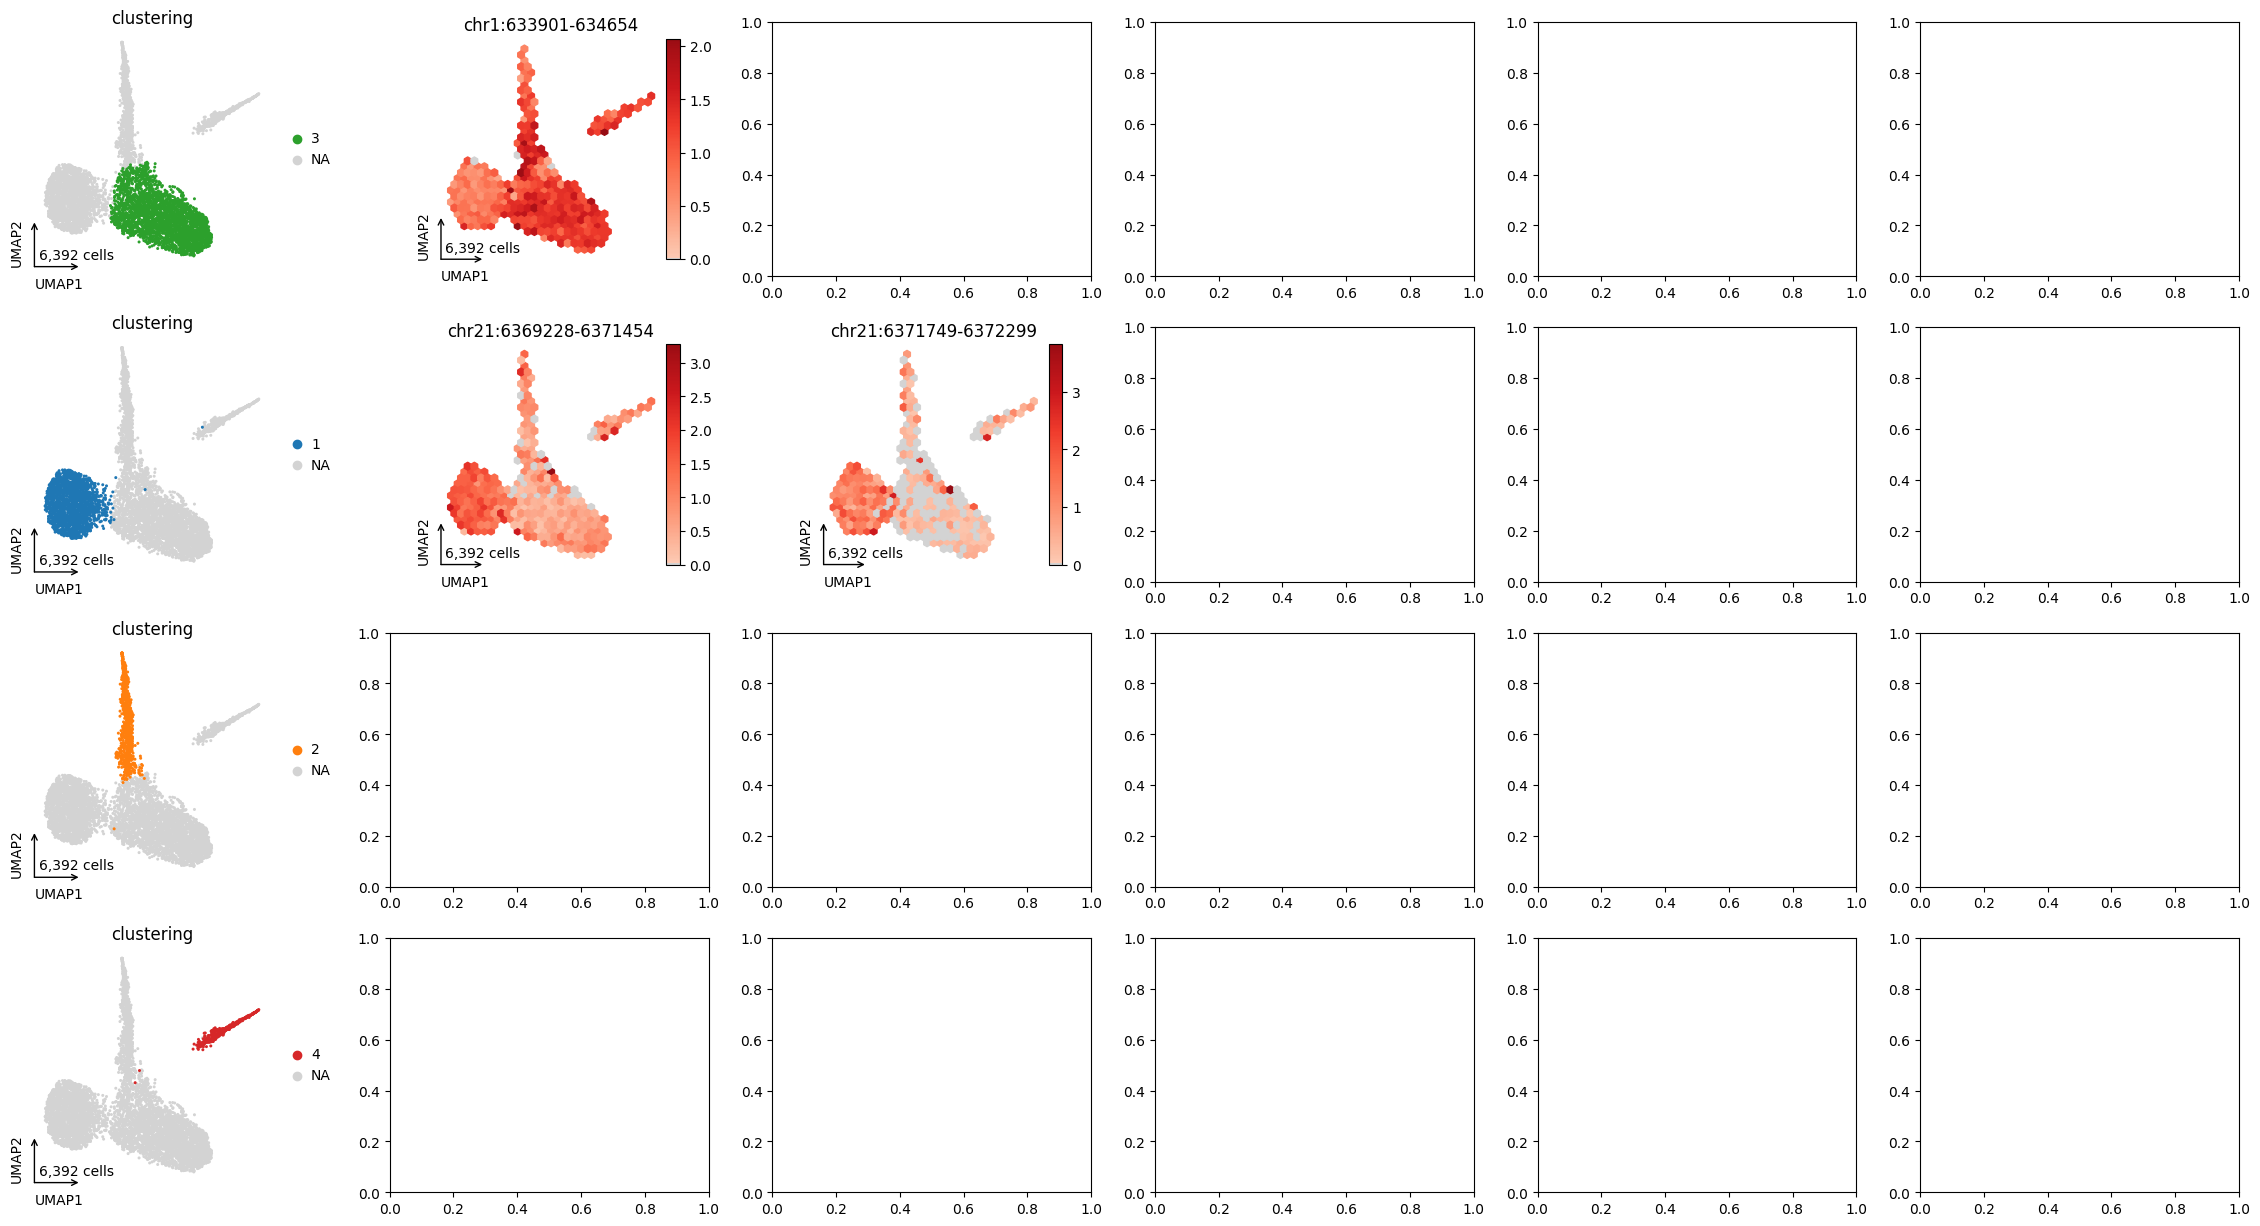

In [26]:
_ = pl.embedding.feature_per_group(
    adata=adata,
    y=y,
    top_n=n_marker,
    marker_key=f"rank_feature_{final_clustering}_filtered",
    style=style,
    save=f"{embedding}_clustering_{y}_top_{n_marker}_markers.pdf",
    method=embedding
)

Show the top n markers expression binarized next to their respective group. This plot highlights where markers have a minimum expression level, making it easier to identify clusters with a high expression of the marker.

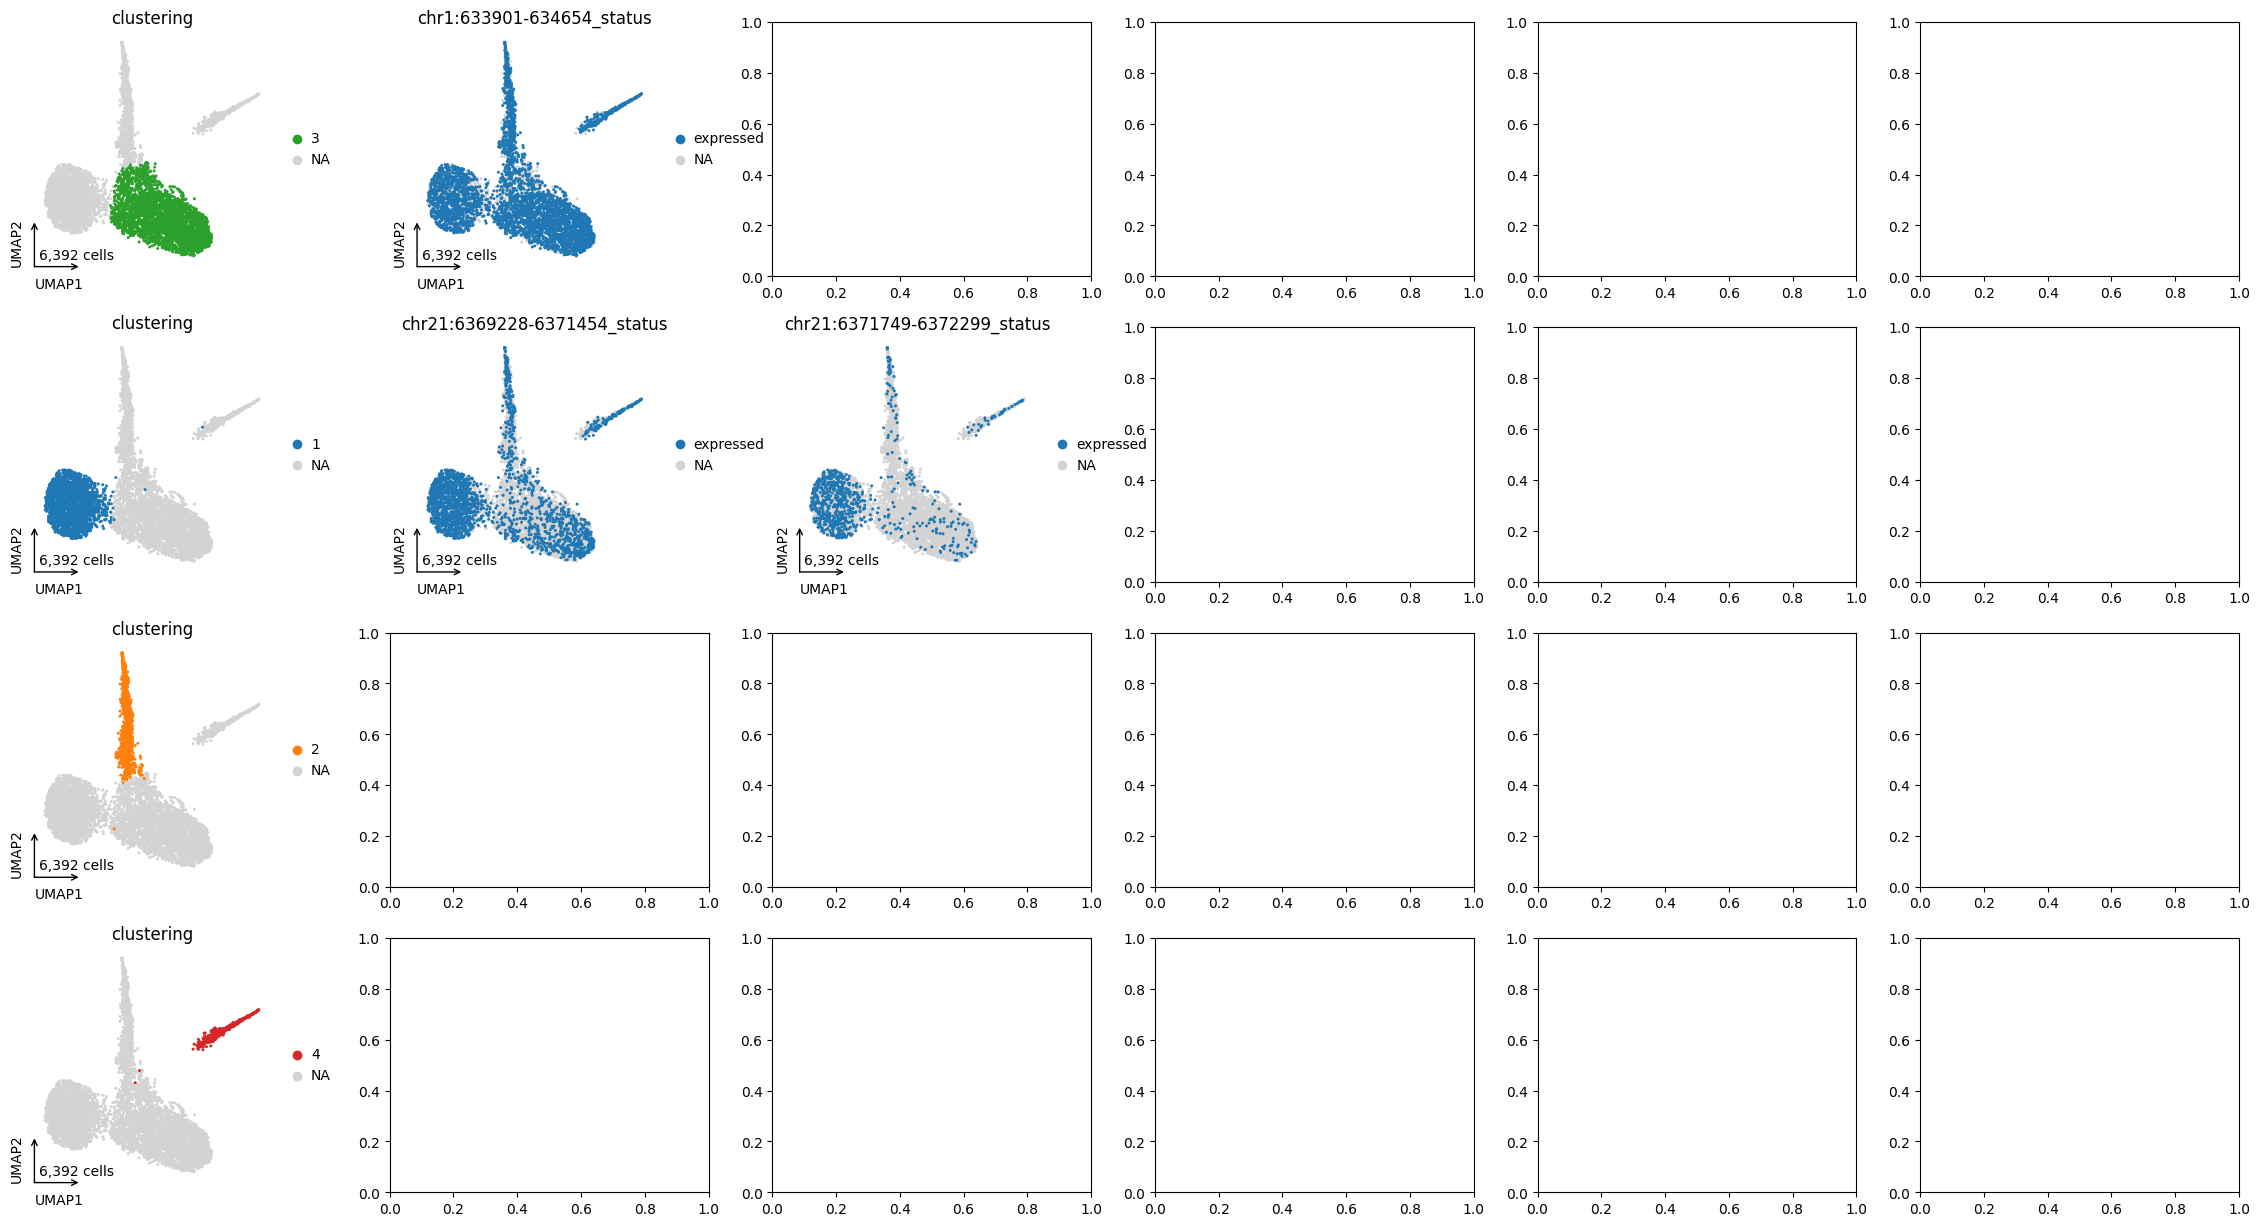

In [27]:
_ = pl.embedding.feature_per_group(
    adata=adata,
    y=y,
    top_n=n_marker,
    marker_key=f"rank_feature_{final_clustering}_filtered",
    binarize_threshold=binarize_threshold,
    binarize_percentile_threshold=binarize_threshold_percentile,
    style=style,
    save=f"{embedding}_clustering_{y}_top_{n_marker}_markers_binarized.pdf",
    method=embedding
)

---------

## 6 - Condition related markers
Until this point markers were computed to identify differences between the previously created cluster groups. However, most experiments provide additional information (e.g. ill vs. healthy, wild-type vs. mutant, etc.). This section aims to use these conditions to identify changes within the above selected clusters.

In [ ]:
with pd.option_context("display.max.rows", 5, "display.max.columns", None):
    display(adata.obs)

<h1><center>⬐ Fill in input data here ⬎</center></h1>

In [6]:
%bgcolor PowderBlue

# Both variables expect a column name from above (adata.obs)
clustering_col = final_clustering  # the clustering e.g. the one chosen in the prior section
condition_col = "chamber"  # the condition used to find changes within each cluster

____

The dataset is split on each cluster and a ranking is performed on each individual subset.

In [ ]:
# split adata by group, then rank features on each
adata_cond = {}

for cluster in set(adata.obs[clustering_col]):
    print(f"Cluster {cluster}")
    adata_sub = adata[adata.obs[clustering_col] == cluster]

    # Check if sample count is sufficent
    value_counts = adata_sub.obs[condition_col].value_counts()
    insufficient_size = [i for i in value_counts.index if value_counts[i] == 1]
    if insufficient_size: 
        print(f"Removed conditions due to insufficent size {insufficient_size}")
        adata_sub = adata_sub[~adata_sub.obs[condition_col].isin(insufficient_size)]

    if len(set(adata_sub.obs[condition_col])) < 2:
        print(f"Skipped Cluster {cluster}")
        continue

    tools.marker_genes.run_rank_genes(
        adata_sub,
        condition_col,
        min_in_group_fraction=min_in_group_fraction,
        min_fold_change=min_fold_change,
        max_out_group_fraction=max_out_group_fraction,
        n_genes=top_n,
        ranking_method=ranking_method
    )
    
    adata_cond[cluster] = adata_sub

One dotplot per group (cluster) showing the top differential features.

In [ ]:
for key, value in adata_cond.items():
    # Plot dotplot of markers
    _ = pl.marker_genes.rank_genes_plot(
        value,
        key=f"rank_genes_{condition_col}_filtered",
        n_genes=n_features_markerplot,
        style=marker_style,
        title=key,
        save=f"{marker_style}_{condition_col}_cluster_{key}.pdf"
    )

In [ ]:
# write marker tables
for key, value in adata_cond.items():
    # Write marker genes to table
    deg_table = tools.marker_genes.get_rank_genes_tables(
        value,
        out_group_fractions=True,
        key=f"rank_genes_{condition_col}_filtered",
        save_excel=f"{condition_col}_cluster_{key}.xlsx"
    )

---------

 ## 7 - Run DEseq2 between conditions/samples

 <h1><center>⬐ Fill in input data here ⬎</center></h1>

In [7]:
%bgcolor PowderBlue

# Adjust which columns to use for DEseq2
sample_col = "sample"
condition_col = "chamber"

___

In [ ]:
# Normalize raw counts across cells
d = sc.pp.normalize_total(adata, layer="raw", inplace=False) # returns a dict
adata.layers["raw_norm"] = d["X"]
adata.layers["raw_norm"] = adata.layers["raw_norm"].ceil().astype(int)

In [ ]:
# Run DEseq2import numpy as np
deseq_table = tools.marker_genes.run_deseq2(adata, sample_col, condition_col, layer="raw_norm")

The DEseq2 result table (below) shows the top 10 differential features sorted after the p-value of the first two conditions.

| Column | Description |
|--------|-------------|
|`[condition]_mean`|The mean expression of the respective feature within the given condition.|
|`[condition 1]/[condition 2]_log2FoldChange`|Log2 of the quotient of the two conditions mean expression. Values `>0` can be interpreted as "more expression in 'condition 1'" and `<0` as "more expression in 'condition 2'".|
|`[condition 1]/[condition 2]_pvalue`|The convidence if a feature is expressed differentially between the two conditions. Closer to zero = better. `<=0.05` is typically considered significant.|
|`[condition 1]/[condition 2]_padj`|The p-value (see above) adjusted for the number of tests (here features).|
|`[sample][condition]`|The mean feature expression within the respective sample and condition.|
|`baseMean`|The mean expression over each sample split by condition (see above).|

In [ ]:
with pd.option_context("display.max.rows", 10, "display.max.columns", None):
    display(deseq_table.head(10))
print(f"{len(deseq_table)} rows x {len(deseq_table.columns)} columns")

In [ ]:
deseq_table.to_excel(f"{sctoolbox.settings.table_dir}/DEseq_{sample_col}_vs_{condition_col}.xlsx")

---------

## 8 - Save adata

In [ ]:
utils.adata.save_h5ad(adata, "anndata_marker.h5ad")